In [1]:
# needed
import os
import re
import soundfile as sf
from IPython.display import Audio
from IPython.display import display
import numpy as np
# recommended ...
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, ifft, fftfreq
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
# read data
login = "xvadova00"
zip_file = "known" + ".zip"
for name in ("known.zip", "valid.zip", login + ".zip"):
  file = "https://www.fit.vut.cz/study/course/ISS/public/proj2025-26/" + name
  !rm $name
  !wget $file
  !unzip -o -q $name

In [3]:
# load the known data - the function returns a big matrix with all the signals
def load_data (S, dirname, count, no_samples):
  ii = 0
  for one in np.arange(count):
    S[ii], Fs = sf.read(dirname + "/" + str(one) + ".wav")
    ii = ii+1

Fs = 16000
# load known data
N_known = 706; duration_known = 10; no_samples_known = Fs * duration_known
known_signals=np.zeros([N_known, no_samples_known]); load_data(known_signals, "known", N_known, no_samples_known)
display(Audio(known_signals[40], rate=Fs))

spectogram_valid=[]
spectogram_known=[]
spectogram_eval=[]

# load validation data
N_valid = 50; duration_valid = 5; no_samples_valid = Fs * duration_valid
valid_signals=np.zeros([N_valid, no_samples_valid]); load_data(valid_signals, "valid", N_valid, no_samples_valid)
display(Audio(valid_signals[45], rate=Fs))

In [4]:
# YOUR CODE COMES HERE ! Your task is to produce a matrix 50 x 706 with similarity measures
def compute_similarity_matrix(N_valid, N_known,spectogram_valid,spectogram_known):
  #Napad na krizovu korelacie som mal z prednasok, kde bola spomenuta ako jedno z rieseni projektu.
  similarities = np.zeros((N_valid, N_known))      #inicalizacia
  i=0
  j=0
  for i in range (N_valid):
    for j in range (N_known):
      similarity = signal.fftconvolve(spectogram_valid[i], spectogram_known[j][::-1, ::-1], mode='valid')  #Vypocet krizovej korelacie pomocou FFT konvolucie
      evaluation = np.max(similarity) #Maximum predstavuje najlepsiu zhodu medzi signalmi
      similarities[i,j] = evaluation
  return similarities

In [5]:
# evaluation - the function produces Top-1 and Top-5 accuracy on validation data
def eval(scores, key):
  indices = np.flip(np.argsort(scores), axis=-1) # we want highest to lowest ...
  #print(scores[0,key[0]], key[0], indices)
  top1acc = np.sum(key == indices[:,0]) / indices.shape[0]
  top5acc = 0
  for ii in range(5):
    top5acc += np.sum(key == indices[:,ii])
  top5acc /=  indices.shape[0]
  return top1acc, top5acc

key = np.loadtxt("valid/key.txt", delimiter = ',', usecols=(1), dtype ='int')

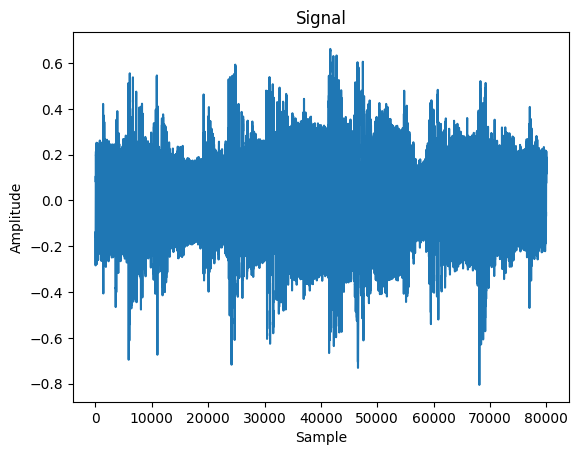

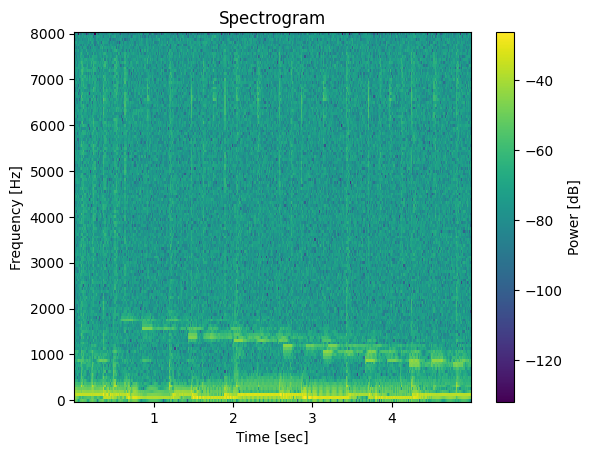

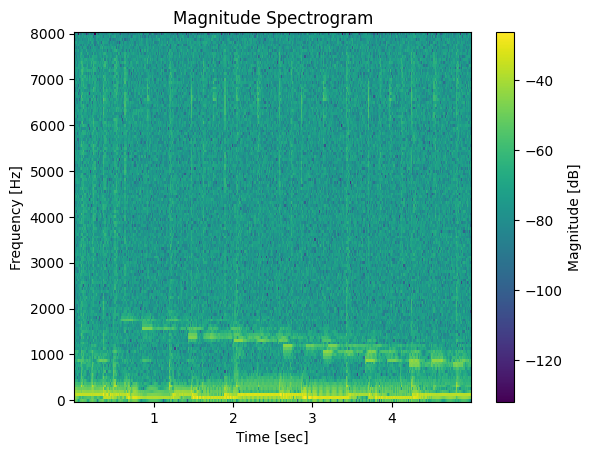

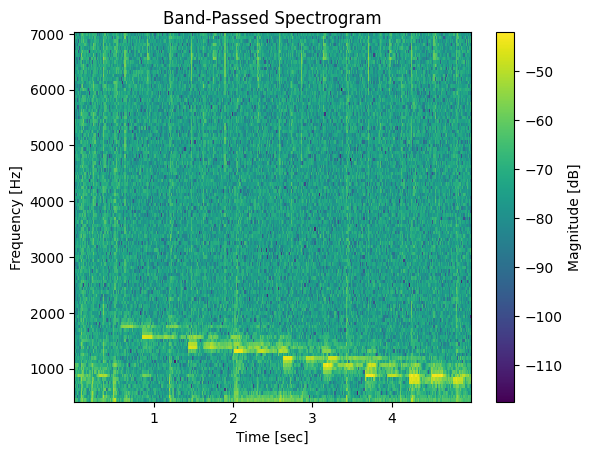

In [6]:
# NOW on YOUR DATA ! Your task is to produce a matrix 50 x 706 with similarity measures

# load your data
N_eval = 50; duration_eval = 5; no_samples_eval = Fs * duration_eval
eval_signals=np.zeros([N_eval, no_samples_eval]); load_data(eval_signals, login, N_eval, no_samples_eval)
#display(Audio(valid_signals[45], rate=Fs))
# YOUR CODE COMES HERE ! Your task is to produce a matrix 50 x 706 with similarity measures

#Vybral som si nahodny signal a vykreslil som ho
plt.figure()
plt.plot(valid_signals[0])
plt.title("Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()
#Spravil som zo singalu spektogram
plt.figure()
f,t,Sxx = signal.spectrogram(valid_signals[0], Fs)
plt.pcolormesh(t,f,10*np.log10(Sxx))       #pouzivame koeficient 10, pretoze Sxx obsahuje vykon
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Power [dB]')
plt.show()
#zobral som z neho iba amplitudovu zlozku
plt.figure()
Sxx = np.sqrt(Sxx)
plt.pcolormesh(t,f,20*np.log10(Sxx))      #pouzivame koeficient 20, pretoze Sxx obsahuje teraz amplitudu
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Magnitude Spectrogram')
plt.colorbar(label='Magnitude [dB]')
plt.show()
#Vybral som take frekvencie, ktore mi davali najlepsie vysledky
plt.figure()
Sxx=Sxx[(f >= 400) & (f <= 7000), :]
f_after=f[(f >= 400) & (f <= 7000)]
plt.pcolormesh(t,f_after,20*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Band-Passed Spectrogram')
plt.colorbar(label='Magnitude [dB]')
plt.show()

i=1 # jednotka, lebo uz prvy je spraveny
for i in range (N_valid):
    f,t,Sxx=signal.spectrogram(valid_signals[i],Fs)     #spravil som zo vsetkych valid signalov spektogram
    Sxx = np.sqrt(Sxx)                                  #zobral som z nich iba amplitudovu slozku 
    Sxx=Sxx[(f >= 400) & (f <= 7000), :]                #zobral som take frekvencie, ktore mi davali najlepsie vysledky
    Sxx=(Sxx-np.mean(Sxx))/np.std(Sxx)                  #znormoval som 
    spectogram_valid.append(Sxx)                        #pridal som do zoznamu
for j in range (N_known):                               #to iste aj pre known signaly
    f,t,Sxx=signal.spectrogram(known_signals[j],Fs)           
    Sxx = np.sqrt(Sxx)
    Sxx=Sxx[(f >= 400) & (f <= 7000), :]
    Sxx=(Sxx-np.mean(Sxx))/np.std(Sxx)
    spectogram_known.append(Sxx)
for h in range (N_eval):                               #to iste aj pre eval signaly
    f,t,Sxx=signal.spectrogram(eval_signals[h],Fs)           
    Sxx = np.sqrt(Sxx)
    Sxx=Sxx[(f >= 400) & (f <= 7000), :]
    Sxx=(Sxx-np.mean(Sxx))/np.std(Sxx)
    spectogram_eval.append(Sxx)

# complete stupid dolution just for testing the export of file with results ...
scores_matrix = compute_similarity_matrix(N_eval, N_known,spectogram_eval,spectogram_known)
# export it
np.savetxt("eval.txt", scores_matrix)

# to download it in Google Colab click on the folder icon in the left column, find eval.txt and download it as usually.

In [9]:
# here comes the computation and evaluation on validation data ...
scores_matrix = compute_similarity_matrix(N_valid, N_known,spectogram_valid,spectogram_known)
#print (key)
top1, top5 = eval(scores_matrix, key)
print("Top 1 accuracy ", top1 * 100, "%, Top 5 accuracy ", top5 * 100, "%" )

Top 1 accuracy  98.0 %, Top 5 accuracy  100.0 %
